# Challenge

This challenge is designed to increase difficulty gradually. First, we will start by gaining some intuition about the different steps of the problem by looking at different circuits and topologies of 5-qubit chips. As the final part of the challenge, we will guide you to design your own routing algorithm.

## Warm up - GHZ state on star topology

In Qilimanjaro, we have access to a 5-qubit digital chip with a star topology (FIG.1). In this topology, all two-qubit gates need to be implemented using the central qubit as a mediator. You can start by considering that the central qubit is bidireccional, i.e., it can be used as a control or target qubit. 

<p style="text-align: center"><img src="https://i.imgur.com/tVLBLaG.png" width=400 /></p>

*FIG.1: Star topology with 5 qubits.*

As a first step, we will generate a state of particular importance for quantum computation and physics, the Greenberger–Horne–Zeilinger (GHZ) state.   The GHZ state is a maximally entangled state, meaning that the qubits are highly correlated with each other and therefore, any measurement on one qubit will instantaneously affect the state of the other qubits. The GHZ state is a superposition of all qubits being in the state $|0\rangle$ and all qubits being in the state $|1\rangle$ and it is generated by the following circuit (FIG.2).

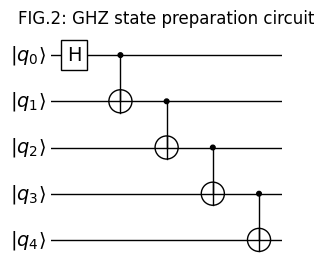

In [38]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

c = models.Circuit(5)

c.add(gates.H(0))
c.add(gates.CNOT(0,1))
c.add(gates.CNOT(1, 2))
c.add(gates.CNOT(2, 3))
c.add(gates.CNOT(3, 4))

#c.add(gates.CNOT(0, 2))
#c.add(gates.M(0, 1,2,3,4))
ax, fig = plot_circuit(c)
ax.set_title("FIG.2: GHZ state preparation circuit")
plt.show()



In [39]:
# Execute the circuit with the default initial state |00000>.
result = c(nshots=1)
print(result)

(0.70711+0j)|00000> + (0.70711+0j)|11111>


### Question
Considering a the star topology of FIG.1, can you implement the GHZ preparation circuit with the necessary SWAPS to implement it?

## Exercise 1

Now consider the circuit from FIG.2. Your mission is to implement this circuit in the star topology by following the steps below:
1. Divide the circuit into timeslices.
2. Determine the initial placement of the qubits such that the maximum number of two-qubit gates can be implemented without SWAPS. This may not be trivial to see so you can always try a random placement, the only problem is that you will have to implement more SWAPS, which is the metric we want to minimize throughout the challenge.
3. Once the initial placement is defined, how many extra SWAPS do you need to implement the circuit? 
4. Now imagine that the central qubit is unidirectional (the case of real quantum hardware), i.e., it can only be used as a control qubit. How much does the depth of the circuit increase in this case?
5. Is there any trivial gate cancellation that can be done to reduce the depth of the circuit? (i.e. two CNOTs in sequence are just the identity. Same with two contiguous Hadamards).
6. Give a method to verify that your resulting circuit represents the same unitary as the original one, i.e. both circuits are equivalent.

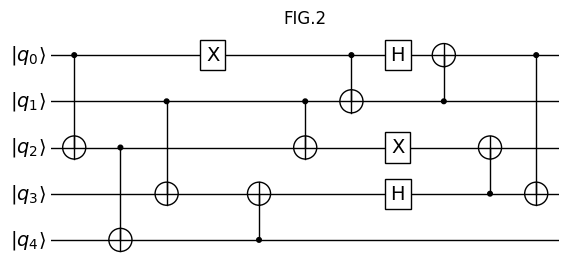

In [40]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

c = models.Circuit(5)
c.add(gates.CNOT(0, 2))
c.add(gates.CNOT(2, 4))
c.add(gates.CNOT(1, 3))
c.add(gates.X(0))
c.add(gates.CNOT(4, 3))
c.add(gates.CNOT(1, 2))
c.add(gates.CNOT(0, 1))
c.add(gates.X(2))
c.add(gates.H(0))
c.add(gates.H(3))
c.add(gates.CNOT(1, 0))
c.add(gates.CNOT(3, 2))
c.add(gates.CNOT(0,3))
ax, fig = plot_circuit(c)
ax.set_title("FIG.2")
plt.show()

## Exercise 2

Consider now the following topologies for a 5-qubit chip: the T-topology (FIG.3) and the chain topology (FIG.4). Follow the previous steps and compare the number of SWAPS needed to implement the circuit from FIG.2 in these two topologies. What conclusions can you draw from this comparison?

<p style="text-align: center"><img src="https://i.imgur.com/6SeZYmO.png" width=400 /></p>


*FIG.3: T-topology with 5 qubits*

<p style="text-align: center"><img src="https://i.imgur.com/vKNOWlh.png" width=400 /></p>

*FIG.4: Chain topology with 5 qubits*

## Exercise 3 

In real hardware, we have a fixed topology and a rich variety of circuits, with different connectivies and so on. Most likely the circuit executable will not be directly mappable to the topology of the hardware. It is imperative to have a compilation procedure that, among other tasks, deals with the qubit routing. In this exercise, we will design our own algorithm for qubit routing, beware that this is not a trivial task! 
The algorithm proceeds in four stages: decomposing the input circuit into timesteps; determining an initial placement; routing across timesteps; and a final clean-up phase (optional).

For simplification purposes, we will design the qubit routing algorithm using the circuit from the tutorial but, once finished, we can test it on the circuits from the previous exercises. Again, the circuit is: 

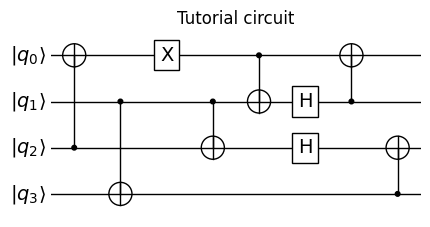

In [41]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

c = models.Circuit(4)
c.add(gates.CNOT(2, 0))
c.add(gates.CNOT(1, 3))
c.add(gates.X(0))
c.add(gates.CNOT(1, 2))
c.add(gates.CNOT(0, 1))
c.add(gates.H(1))
c.add(gates.H(2))
c.add(gates.CNOT(1, 0))
c.add(gates.CNOT(3, 2))
ax, fig = plot_circuit(c)
ax.set_title("Tutorial circuit")
plt.show()

### A. Slicing the circuit into timesteps

Before routing we partition the quantum circuit into timesteps. The circuit structure provides a
natural partial ordering of the gates; thus a greedy algorithm starting from inputs can divide the input circuit into “horizontal” partitions of gates which can be executed simultaneously. We simply traverse the circuit adding the qubits involved in a 2-qubit gate to the current timestep. Since only multiqubit interactions (such as CNOT or CZ gates) constrain the problem, single qubit gates can be ignored (fMore accurately: while the single qubit gates can be ignored for the purposes of routing, they must be retained for circuit generation; for clarity we ignore them for now).

If a gate requires a qubit already used in the previous timestep, a new timestep is created. This procedure is repeated until all gates are assigned to a timestep. A timestep thus consists of a set of disjoint pairs of (logical) qubits which represent gates scheduled for simultaneous execution.

#### Q1. Can you obtain the timesteps for the circuit of the tutorial? 
*Note, that this is may not the same as the illustrative slicing shown in FIG.2 from the tutorial!*